In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored as cl
import yfinance as yf
import math
plt.rcParams['figure.figsize'] = (40,20)

In [2]:
# Tickers List
#Snp_500= ["V", "INTC", "CAT", "LLY", "DIS", "TSLA", "GS", "BA", "CSCO","ABBV",
#           "AMZN", "JPM", "KO", "MCD", "PYPL", "WMT", "IBM", "AMGN", "REGN", "JNJ"]
Apple = ["AAPL"]

In [3]:
# Time period for the data ( 2 years)
final_date = '2023-11-30'
start_date = '1993-01-01'

In [4]:
# Creating a function to record the daily returns
def get_stock_data(tickers, start_date, end_date):
    # Empty DataFrame to storing daily returns
    df_returns = pd.DataFrame()

    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        df_returns["Close"] = stock['Close']
        df_returns["High"] = stock['High']
        df_returns["Low"] = stock['Low']
    return df_returns

In [5]:
# Running the function to get data
aapl = get_stock_data(Apple,start_date,final_date)
aapl = aapl.dropna()

[*********************100%%**********************]  1 of 1 completed


In [6]:
#data[['dcl','dcm','dcu']] = data.ta.donchain(lower_length = 40, upper_length = 50)
N = 20
aapl['upper_channel'] = aapl['High'].rolling(N).max().shift(N-20)
aapl['lower_channel'] = aapl['Low'].rolling(N).min().shift(N-20)
aapl['middle_channel'] = ((aapl['upper_channel']+aapl['lower_channel'])/2)
aapl['donchain_width'] = aapl['upper_channel'] - aapl['lower_channel']

Text(0, 0.5, 'Close')

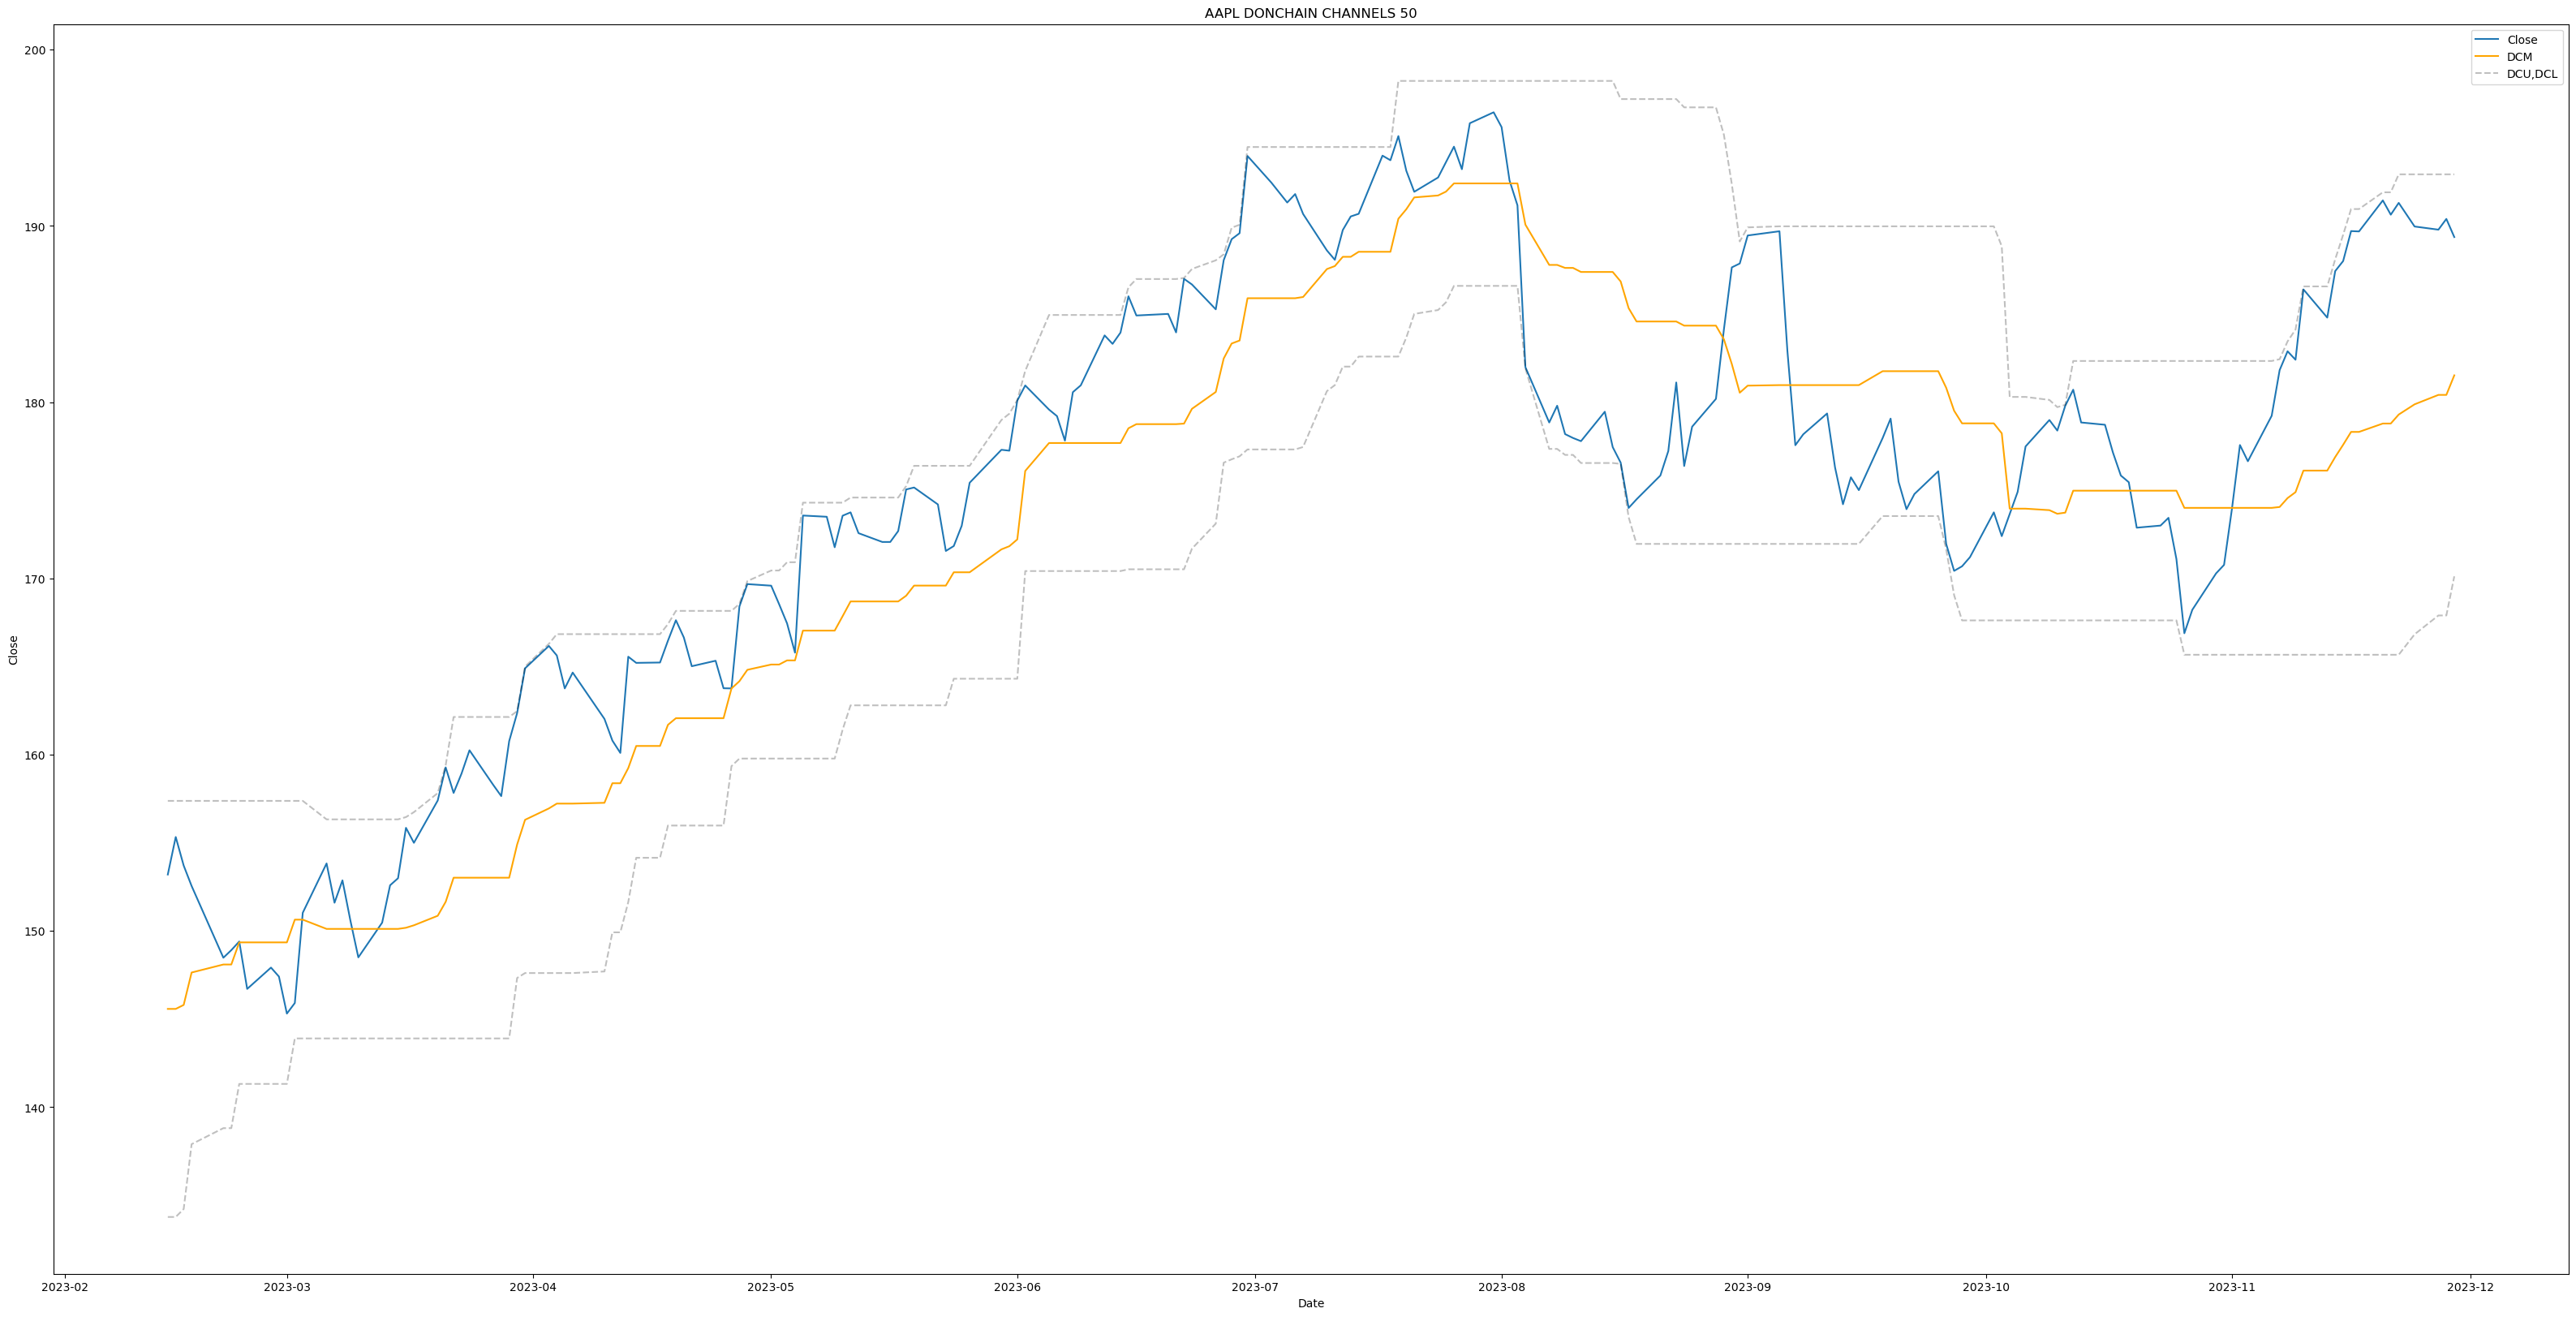

In [7]:
# Plotting Donchain channel
plt.plot(aapl[-200:].Close, label = 'Close')
plt.plot(aapl[-200:].lower_channel, color = 'black', linestyle = '--', alpha = 0.25)
plt.plot(aapl[-200:].middle_channel, color = 'orange', label='DCM')
plt.plot(aapl[-200:].upper_channel, color = 'black', linestyle = '--', alpha = 0.25, label='DCU,DCL')
plt.legend()
plt.title('AAPL DONCHAIN CHANNELS 50')
plt.xlabel('Date')
plt.ylabel('Close')

In [8]:
# Analyze buy and sell signals
buy_signals = []
sell_signals = []

def signal_output(stock):
    
    for i in range(len(stock)):
        if (stock['High'][i] >= stock['upper_channel'][i]) and (stock['middle_channel'][i-1] < stock['upper_channel'][i]) and (stock['donchain_width'][i-1] <= stock['donchain_width'][i]):
            buy_signals.append(i)
        elif (stock['Low'][i] <= stock['lower_channel'][i]) and (stock['middle_channel'][i-1] > stock['lower_channel'][i]) and (stock['donchain_width'][i-1] >= stock['donchain_width'][i]):
            sell_signals.append(i)
    
    stock['Buy Signal'] = [1 if i in buy_signals else 0 for i in range(len(stock))]
    stock['Sell Signal'] = [1 if i in sell_signals else 0 for i in range(len(stock))]
            
signal_output(aapl)

In [9]:
# Activity Dataframe when either a buy or sell activity happens
mask = (aapl['Buy Signal'] == 0) & (aapl['Sell Signal'] == 0)
activity_aapl = aapl[~mask]

In [10]:
if activity_aapl.iloc[0]['Sell Signal'] == 1:
  activity_aapl = activity_aapl.iloc[1:]
  
last_day = aapl.tail(1)
activity_aapl = pd.concat([activity_aapl, last_day], ignore_index=False)

In [11]:
# Backtesting Strategy
def implement_strategy(stock,investment):
    equity = investment
    shares = 0
    
    for i in range(len(stock)):
        if stock['Buy Signal'].iloc[i] == 1:
            shares_buy = math.floor((0.1 * equity)/stock.Close[i])
            shares += shares_buy
            position_open = (shares_buy * stock.Close[i])
            equity -= position_open 
            print(cl('BUY: ', color = 'green', attrs = ['bold']), f'{shares_buy} Shares are bought at ${stock.Close[i]} on {str(stock.index[i])}')
        elif stock['Sell Signal'].iloc[i] == 1:
            shares_sell = math.floor(0.15 * shares)
            shares -= shares_sell
            position_close = (shares_sell * stock.Close[i])
            equity += position_close
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{shares_sell} Shares are sold at ${stock.Close[i]} on {str(stock.index[i])}')
    
    equity += shares * stock.Close[i]
    print(cl(f'\nClosing position at ${stock.Close[i]} on {str(stock.index[i])}', attrs = ['bold']))
    earning = round(equity - investment,2)
    roi = round((earning / investment) * 100 , 2)
    print(cl(f'Earning: $ {earning} ; ROI: {roi}%', attrs = ['bold']))

In [12]:
implement_strategy(activity_aapl,1000000)

BUY:  197357 Shares are bought at $0.5066959857940674 on 1993-03-09 00:00:00
SELL:  29603 Shares are sold at $0.4754459857940674 on 1993-03-26 00:00:00
SELL:  25163 Shares are sold at $0.4464290142059326 on 1993-04-05 00:00:00
SELL:  21388 Shares are sold at $0.43526801466941833 on 1993-04-14 00:00:00
SELL:  18180 Shares are sold at $0.421875 on 1993-04-15 00:00:00
BUY:  205924 Shares are bought at $0.4575890004634857 on 1993-04-30 00:00:00
BUY:  177953 Shares are bought at $0.4765630066394806 on 1993-05-04 00:00:00
BUY:  156852 Shares are bought at $0.48660698533058167 on 1993-05-05 00:00:00
BUY:  139883 Shares are bought at $0.4910709857940674 on 1993-05-10 00:00:00
BUY:  124201 Shares are bought at $0.49776801466941833 on 1993-05-17 00:00:00
BUY:  112284 Shares are bought at $0.4955359995365143 on 1993-05-18 00:00:00
BUY:  97967 Shares are bought at $0.5111610293388367 on 1993-05-19 00:00:00
BUY:  85919 Shares are bought at $0.5245540142059326 on 1993-05-20 00:00:00
BUY:  79008 Shar